In [65]:
# !gdown --id 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q

In [66]:
# !unzip dataset.zip

In [67]:
# !pip install unidecode

In [68]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 1. Read Dataset

In [69]:
dataset_path = 'dataset/all-data.csv'
header = ['sentiment','content']
df = pd.read_csv(dataset_path, names=header, encoding='ISO-8859-1')

In [70]:
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [71]:
classes = {
    classes_name: idx for idx, classes_name in enumerate(df['sentiment'].unique().tolist())
}

df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


#### 2. Data Reprocessing

In [72]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '',text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    return text

In [73]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))
df.head()

,sentiment,content
0,0,accord gran compani plan move product russia ...
1,0,technopoli plan develop stage area less 100000...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year 20092012 b...


#### 3. Build Vocab

In [74]:
vocab = []
for sentence in df['content'].tolist():
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [75]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for word in text.split():
        try:
            word_ids = word_to_idx[word]
        except:
            word_ids = word_to_idx['UNK']
        tokens.append(word_ids)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]
    return tokens

#### 4. Split Train - Valid - Test

In [76]:
val_size = 0.2
test_size = 0.125
is_shuffe = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    shuffle=is_shuffe,
    random_state=seed
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    shuffle=is_shuffe,
    random_state=seed
)

#### 5. Build Pytorch Dataset

In [77]:
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(text, self.word_to_idx, self.max_seq_len)

        text = torch.tensor(text)

        return text, label

In [78]:
max_seq_len = 32

train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

In [79]:
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

#### 6. Build Model

In [80]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, droupout_prob):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(droupout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [81]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [82]:
model = SentimentClassifier(vocab_size, embedding_dim=embedding_dim, hidden_size=hidden_size, n_layers=n_layers, n_classes=n_classes, droupout_prob=dropout_prob)
model.to(device)

SentimentClassifier(
  (embedding): Embedding(8908, 64)
  (rnn): RNN(64, 64, num_layers=2, batch_first=True)
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)

In [83]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### 7. Training

In [84]:
def fit(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


In [85]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc

In [86]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, epochs, device)

Epoch: 1/50 | Train Loss: 1.0049 | Val Loss: 0.9399
Epoch: 2/50 | Train Loss: 0.9462 | Val Loss: 0.9162
Epoch: 3/50 | Train Loss: 0.9361 | Val Loss: 0.9107
Epoch: 4/50 | Train Loss: 0.9320 | Val Loss: 0.9097
Epoch: 5/50 | Train Loss: 0.9316 | Val Loss: 0.9092
Epoch: 6/50 | Train Loss: 0.9305 | Val Loss: 0.9083
Epoch: 7/50 | Train Loss: 0.9274 | Val Loss: 0.9085
Epoch: 8/50 | Train Loss: 0.9307 | Val Loss: 0.9088
Epoch: 9/50 | Train Loss: 0.9286 | Val Loss: 0.9081
Epoch: 10/50 | Train Loss: 0.9340 | Val Loss: 0.9080
Epoch: 11/50 | Train Loss: 0.9317 | Val Loss: 0.9080
Epoch: 12/50 | Train Loss: 0.9353 | Val Loss: 0.9089
Epoch: 13/50 | Train Loss: 0.9335 | Val Loss: 0.9081
Epoch: 14/50 | Train Loss: 0.9363 | Val Loss: 0.9083
Epoch: 15/50 | Train Loss: 0.9261 | Val Loss: 0.9086
Epoch: 16/50 | Train Loss: 0.9285 | Val Loss: 0.9077
Epoch: 17/50 | Train Loss: 0.9348 | Val Loss: 0.9076
Epoch: 18/50 | Train Loss: 0.9327 | Val Loss: 0.9084
Epoch: 19/50 | Train Loss: 0.9350 | Val Loss: 0.9078
Ep

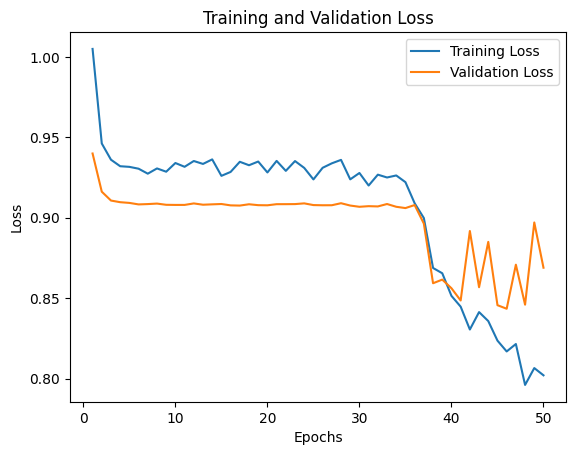

In [87]:
# prompt: visualize plot train_loss and val_loss

import matplotlib.pyplot as plt


epochs = range(1, len(train_losses) + 1) # Assuming epochs is defined

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### 8. Evaluate Model

In [88]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Valid accuracy: {val_acc:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

Valid accuracy: 0.6095
Test accuracy: 0.6095
